# 带钢表面缺陷分类识别

### 1.导入相关的Python包

In [94]:
import pandas as pd
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #训练集，测试集划分函数
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans


### 2.数据预处理

#### 导入数据集

In [95]:
# 屏蔽所有警告信息
warnings.filterwarnings('ignore')
# 以 DataFrame 的形式导入标签文件
labels_pd = pd.read_csv('Faults27x7_var', header=None, prefix="0")
# 提取出标签文件的数据
labels_data = labels_pd.values
# 以 DataFrame的形式导入数据集
dataset = pd.read_table('Faults.tsv', header=None, prefix="0")
# 设置数据集的标签
feature_names = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']
class_names = ['Pastry','Z_Scratch','K_Scratch','Stains','Dirtiness','Bumps','Other_Faults']
columns = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
dataset.columns = columns
# 查看数据集
dataset

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


#### 查看数据基本信息

In [96]:
# 查看数据集大小
dataset.shape

(1941, 34)

#### 查看数据集是否有缺失值和离散值

In [97]:
# 查看数据集是否有缺失值
dataset.shape[0] - dataset.count(0)

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scratch                0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

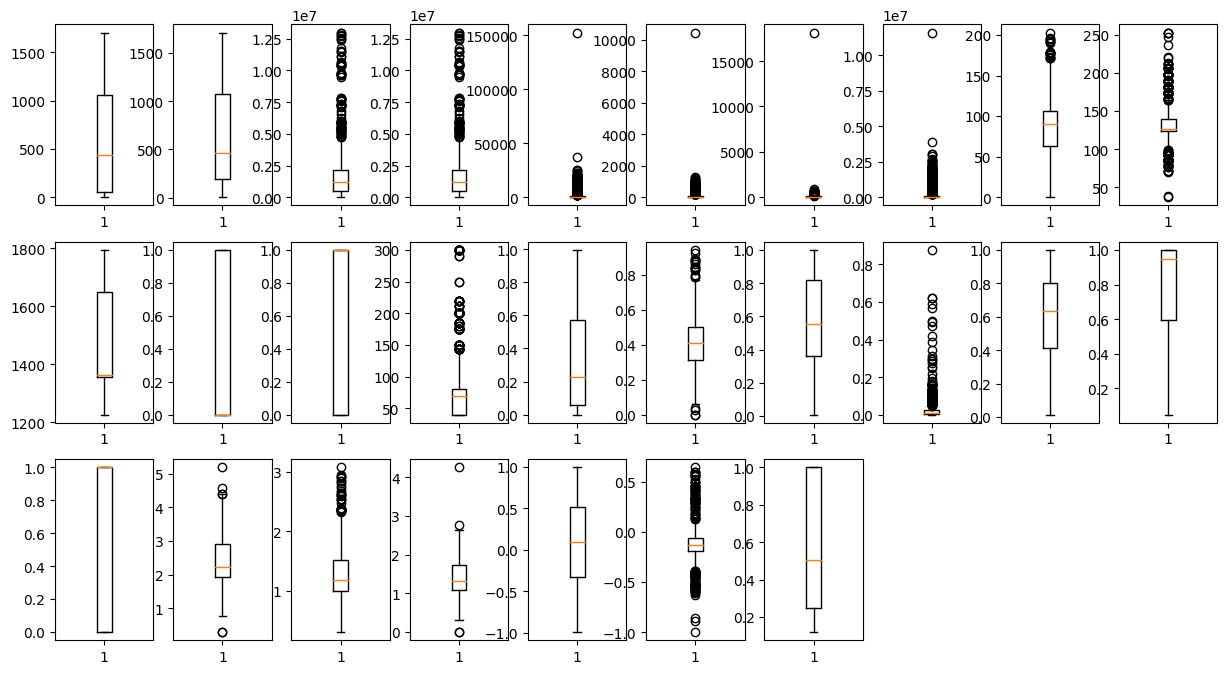

In [98]:
# 查看数据集是否有离散值
# 1.箱型图法
plt.figure(figsize=(15, 8))
for i in range(1, 28, 1):
    plt.subplot(3, 10, i)
    plt.boxplot(dataset[dataset.columns[i - 1]])

In [99]:
# 2.局部离群值因子法(LOF)
clf = LocalOutlierFactor(n_neighbors=20)  # 近邻数是超参数，20为默认值，一般取该值效果不错
dataset_LOF_copy = dataset[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']].copy()
y_pred = clf.fit_predict(np.array(dataset_LOF_copy))  # 结果中-1表离群样本，1表正常样本
LOF_arr = dataset[['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']][y_pred==-1]
LOF_arr

,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
4,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0
9,1,0,0,0,0,0,0
12,1,0,0,0,0,0,0
14,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1749,0,0,0,0,0,0,1
1763,0,0,0,0,0,0,1
1863,0,0,0,0,0,0,1
1891,0,0,0,0,0,0,1


In [78]:
dataset=dataset.drop(index=dataset.index[range(1268,1941)])
dataset

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,221,242,3948212,3948253,519,33,41,48309,65,124,...,0.4878,-0.2728,0.9765,0,0,0,0,0,1,0
1264,1111,1121,4032298,4032320,110,20,22,12351,100,127,...,0.5454,-0.1228,0.3663,0,0,0,0,0,1,0
1265,995,1006,4085316,4085344,140,25,28,16076,103,132,...,0.6071,-0.1029,0.5096,0,0,0,0,0,1,0
1266,396,418,4116853,4116868,231,26,16,25096,56,141,...,-0.3182,-0.1512,0.5461,0,0,0,0,0,1,0


#### 将输入特征与输出特征分开

In [100]:
X = dataset[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']]
# Y = dataset[['Pastry','Z_Scratch','K_Scratch','Stains','Dirtiness','Bumps','Other_Faults']]
# 将dataset数据集转为二维数组
dataset_data = dataset.values
# 将原数据集的Y化简到1维，Pastry为1，Z_Scratch为2，以此类推直到7
Y_data = []
for i in range(len(dataset_data)):
    for j in range(27, 34, 1):
        if (dataset_data[i][j] == 1):
           Y_data.append(j - 27)
# # # 将Y的数据转为英文，便于分析
# # for i in range(len(Y_data)):
# #     if (Y_data[i] == 1):
# #         Y_data[i] = 'Pastry'
# #     elif (Y_data[i] == 2):
# #         Y_data[i] = 'Z_Scratch'
# #     elif (Y_data[i] == 3):
# #         Y_data[i] = 'K_Scratch'
# #     elif (Y_data[i] == 4):
# #         Y_data[i] = 'Stains'
# #     elif (Y_data[i] == 5):
# #         Y_data[i] = 'Dirtiness'
# #     elif (Y_data[i] == 6):
# #         Y_data[i] = 'Bumps'
# #     elif (Y_data[i] == 7):
# #         Y_data[i] = 'Other_Faults'
# for i in range(len(Y_data)):
#     if (Y_data[i] == 0):
#         Y_data[i] = 0
#     elif (Y_data[i] == 1):
#         Y_data[i] = 0
#     elif (Y_data[i] == 2):
#         Y_data[i] = 0
#     elif (Y_data[i] == 3):
#         Y_data[i] = 0
#     elif (Y_data[i] == 4):
#         Y_data[i] = 0
#     elif (Y_data[i] == 5):
#         Y_data[i] = 0
#     elif (Y_data[i] == 6):
#         Y_data[i] = 1
# 输出集
Y = pd.DataFrame(Y_data)
Y.columns = ['category']
Y.value_counts()

category
6           673
5           402
2           391
1           190
0           158
3            72
4            55
dtype: int64

In [101]:
Y_Other_Faults = dataset.drop(index=dataset.index[range(0, 1268)])
Y_Other_Faults = Y_Other_Faults[feature_names]
Y_Other_Faults = Y_Other_Faults.reset_index(drop=True)
Y_Other_Faults_values = Y_Other_Faults.values
Y_Other_Faults

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,1108,1120,2497122,2497138,137,13,16,15672,85,133,...,0.0087,0.9231,1.0000,1.0,2.1367,1.0792,1.2041,0.2500,-0.1063,0.3241
1,333,342,764107,764213,525,16,106,57020,95,127,...,0.0066,0.5625,1.0000,1.0,2.7202,0.9542,2.0253,0.9151,-0.1515,0.9872
2,1269,1296,374730,374925,2463,188,212,296673,42,143,...,0.0200,0.1436,0.9198,1.0,3.3915,1.4314,2.2900,0.8615,-0.0590,1.0000
3,1109,1144,401768,401951,4298,188,189,515942,6,148,...,0.0259,0.1862,0.9682,1.0,3.6333,1.5441,2.2624,0.8087,-0.0622,1.0000
4,1293,1316,600561,600841,2643,170,285,271889,44,125,...,0.0170,0.1353,0.9825,1.0,3.4221,1.3617,2.4472,0.9179,-0.1963,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,249,277,325780,325796,273,54,22,35033,119,141,...,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254
669,144,175,340581,340598,287,44,24,34599,112,133,...,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173
670,145,174,386779,386794,292,40,22,37572,120,140,...,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079
671,137,170,422497,422528,419,97,47,52715,117,140,...,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919


In [92]:
kmeans_model = KMeans(init="k-means++",n_clusters=3)
kmeans_model.fit(Y_Other_Faults)  # 训练是t簇，指定数据源
# 输出各个簇中包含的样本数据
labels = kmeans_model.predict(Y_Other_Faults)
clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(Y_Other_Faults_values[n])
    else:
        clusters[item] = [Y_Other_Faults_values[n]]
    n +=1
for item in clusters:
    print("输出簇： ", item)
    for i2 in clusters[item]:
        print(i2)

输出簇：  1
[ 1.108000e+03  1.120000e+03  2.497122e+06  2.497138e+06  1.370000e+02
  1.300000e+01  1.600000e+01  1.567200e+04  8.500000e+01  1.330000e+02
  1.373000e+03  0.000000e+00  1.000000e+00  4.000000e+01  3.685000e-01
  2.865000e-01  7.500000e-01  8.700000e-03  9.231000e-01  1.000000e+00
  1.000000e+00  2.136700e+00  1.079200e+00  1.204100e+00  2.500000e-01
 -1.063000e-01  3.241000e-01]
[ 3.900000e+01  2.080000e+02  2.410802e+06  2.410860e+06  5.632000e+03
  2.860000e+02  1.410000e+02  5.911110e+05  4.500000e+01  1.250000e+02
  1.356000e+03  0.000000e+00  1.000000e+00  4.000000e+01  5.750000e-02
  4.254000e-01  3.432000e-01  1.246000e-01  5.909000e-01  4.114000e-01
  0.000000e+00  3.750700e+00  2.227900e+00  1.763400e+00 -6.568000e-01
 -1.800000e-01  1.000000e+00]
[ 4.100000e+01  2.120000e+02  2.609514e+06  2.609580e+06  5.951000e+03
  3.020000e+02  1.360000e+02  6.177080e+05  3.800000e+01  1.240000e+02
  1.356000e+03  0.000000e+00  1.000000e+00  4.000000e+01  6.050000e-02
  4.72700

#### 分离测试集和训练集

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=3, stratify=Y)
# test_size:  若为小数，则为测试集样本占总样本的比例；若为整数，则为测试集样本数量
# random_state：随机数的种子，在需要重复试验的时候，指定一个固定值，则得到相同的划分结果
# stratify：划分前是否打乱原始样本顺序
y_train.value_counts()  # 训练集中各类样本数量统计

category
6           605
5           362
2           352
1           171
0           142
3            65
4            49
dtype: int64

#### 对输入数据做标准化

In [103]:
# 利用训练集的参数来标准化测试集
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = feature_names
X_test.columns = feature_names

#### 特征选择

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X_train = SelectKBest(f_classif, k=15).fit_transform(X_train, y_train)
X_train = pd.DataFrame(X_train)
X_train.columns = [['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Length_of_Conveyer','TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_X_Index','Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'SigmoidOfAreas']]
X_test = X_test[['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Length_of_Conveyer','TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_X_Index','Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'SigmoidOfAreas']]

#### 构造模型评价函数

In [104]:
def showCVResults(cv_results):
    print('fit_time:%.4f' % cv_results['fit_time'].mean())
    print('score_time:%.4f' % cv_results['score_time'].mean())
    print('accuracy:%.4f' % cv_results['test_accuracy'].mean())
    print('precision_weighted:%.4f' % cv_results['test_precision_weighted'].mean())
    print('recall_weighted:%.4f' % cv_results['test_recall_weighted'].mean())
    print('f1_weighted:%.4f' % cv_results['test_f1_weighted'].mean())
    print('precision_macro:%.4f' % cv_results['test_precision_macro'].mean())
    print('recall_macro:%.4f' % cv_results['test_recall_macro'].mean())
    print('f1_macro:%.4f' % cv_results['test_f1_macro'].mean())

#### 构造分层的交叉验证迭代器

In [105]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
# 分层划分训练集和测试集，使训练集、测试集中各类别样本数量比例与原始数据集保持一致

In [106]:
# 测试集中各类样本数量统计
y_test.value_counts()

category
6           68
5           40
2           39
1           19
0           16
3            7
4            6
dtype: int64

In [107]:
sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts()

category
0           605
1           605
2           605
3           605
4           605
5           605
6           605
dtype: int64

In [44]:
under = RandomUnderSampler(random_state=0, sampling_strategy='auto')
X_train, y_train = under.fit_resample(X_train, y_train)
y_train.value_counts()

category
0           49
1           49
2           49
3           49
4           49
5           49
6           49
dtype: int64

### 3.使用决策树进行分类

In [52]:
# 不做任何剪枝操作的决策树拟合
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
# 执行交叉验证并进行多指标评估
cv_results_dt = cross_validate(estimator=dtc, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_dt)

fit_time:0.1056
score_time:0.0494
accuracy:0.7264
precision_weighted:0.7279
recall_weighted:0.7264
f1_weighted:0.7246
precision_macro:0.7566
recall_macro:0.7612
f1_macro:0.7549


In [68]:
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       130
           1       0.69      0.72      0.71        65

    accuracy                           0.80       195
   macro avg       0.77      0.78      0.78       195
weighted avg       0.80      0.80      0.80       195



In [ ]:
# 将决策树进行完整的可视化
dtc.fit(X_train, y_train)
export_graphviz(dtc, out_file="D://tree.dot",
                feature_names=feature_names, class_names=class_names,
                filled=True, rounded=True,special_characters=True)

In [ ]:
# 对决策树进行预剪枝和后剪枝
# 后剪枝
path = dtc.cost_complexity_pruning_path(X_train, y_train)
#cost_complexity_pruning_path：返回两个参数，
#第一个是CCP剪枝后决策树序列T0,T1,...,Tt对应的误差率增益率α；第二个是剪枝后决策树所有叶子节点的不纯度
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
# ccp_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
#输出最后一个数的节点个数和ccp_alphas
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
plt.rcParams['savefig.dpi'] = 80 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
# 默认的像素：[6.0,4.0]，分辨率为100，图片尺寸为 600*400
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='', label="test",
        drawstyle="steps-post")
ax.legend()

In [ ]:
# 预剪枝
max_depth = np.arange(1, 20, 1)
dtcs = []
for i in max_depth:
    dtc = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=i)
    dtc.fit(X_train, y_train)
    dtcs.append(dtc)
train_scores = [dtc.score(X_train, y_train) for dtc in dtcs]
test_scores = [dtc.score(X_test, y_test) for dtc in dtcs]
plt.rcParams['savefig.dpi'] = 80 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
# 默认的像素：[6.0,4.0]，分辨率为100，图片尺寸为 600*400
fig, ax = plt.subplots()
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs max_depth for training and testing sets")
ax.plot(max_depth, train_scores, marker='', label="train",
        drawstyle="steps-post")
ax.plot(max_depth, test_scores, marker='', label="test",
        drawstyle="steps-post")
ax.legend()

In [ ]:
# 使用网格搜索法寻求最优参数
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
param_grid = [
    {
        'max_depth': np.arange(1, 20, 1),
        'ccp_alpha': [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
    }
]
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)
# 最佳模型得分
print(grid_search.best_score_)

# 最佳的模型参数
print(grid_search.best_params_)

In [ ]:
dtc = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=9, ccp_alpha=0)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print(classification_report(y_pred, y_test))
# 执行交叉验证并进行多指标评估
# cv_results_dt = cross_validate(estimator=dtc, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
# showCVResults(cv_results_dt)

In [ ]:
# 将决策树进行完整的可视化
dtc.fit(X_train, y_train)
export_graphviz(dtc, out_file="D://tree.dot",
                feature_names=feature_names,class_names=class_names,
                filled=True, rounded=True,special_characters=True)

### 4.支持向量机

In [ ]:
# 0.1 5 0.1 0.1 5 0.1 gamma=0.1 C=4.6 0.7743
model_svm = SVC(kernel='rbf', gamma=0.1, C=4.6)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
print(classification_report(y_pred, y_test))
# cv_results_lr = cross_validate(estimator=model_svm, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
# showCVResults(cv_results_lr)

In [ ]:
linear_svm = SVC(kernel='linear', C=6.7)
linear_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
print(classification_report(y_pred, y_test))
# cv_results_lr = cross_validate(estimator=linear_svm, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
# showCVResults(cv_results_lr)

In [ ]:
C_arr = np.arange(0.1, 5, 0.1)
gamma_arr = np.arange(0.1, 5, 0.1)
param_grid = [
    {
        'C': C_arr,
        'gamma': gamma_arr
    }
]
random_search = RandomizedSearchCV(estimator=model_svm, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)
# grid_search = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring="accuracy", cv=skf)
random_search.fit(X_train, y_train)
# 最佳模型得分
print(random_search.best_score_)
# 最佳的模型参数
print(random_search.best_params_)

In [ ]:
C_arr = np.arange(0.1, 10, 0.1)
param_grid = [
    {
        'C': C_arr,
    }
]
random_search = RandomizedSearchCV(estimator=linear_svm, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)
# grid_search = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring="accuracy", cv=skf)
random_search.fit(X, Y)
# 最佳模型得分
print(random_search.best_score_)
# 最佳的模型参数
print(random_search.best_params_)

In [ ]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import random


# 异常类
class ReliefError:
    pass


class Relief:
    def __init__(self, data_df, sample_rate, t, k):
        """
        #
        :param data_df: 数据框（字段为特征，行为样本）
        :param sample_rate: 抽样比例
        :param t: 统计量分量阈值
        :param k: k近邻的个数
        """
        self.__data = data_df
        self.__feature = data_df.columns
        self.__sample_num = int(round(len(data_df) * sample_rate))
        self.__t = t
        self.__k = k

    # 数据处理（将离散型数据处理成连续型数据，比如字符到数值）
    def get_data(self):
        new_data = pd.DataFrame()
        for one in self.__feature[:-1]:
            col = self.__data[one]
            if (str(list(col)[0]).split(".")[0]).isdigit() or str(list(col)[0]).isdigit() or (str(list(col)[0]).split('-')[-1]).split(".")[-1].isdigit():
                new_data[one] = self.__data[one]
                # print '%s 是数值型' % one
            else:
                # print '%s 是离散型' % one
                keys = list(set(list(col)))
                values = list(xrange(len(keys)))
                new = dict(zip(keys, values))
                new_data[one] = self.__data[one].map(new)
        new_data[self.__feature[-1]] = self.__data[self.__feature[-1]]
        return new_data

    # 返回一个样本的k个猜中近邻和其他类的k个猜错近邻
    def get_neighbors(self, row):
        df = self.get_data()
        row_type = row[df.columns[-1]]
        right_df = df[df[df.columns[-1]] == row_type].drop(columns=[df.columns[-1]])
        aim = row.drop(df.columns[-1])
        f = lambda x: eulidSim(np.mat(x.values), np.mat(aim.values))
        right_sim = right_df.apply(f, axis=1)
        right_sim_two = right_sim.drop(right_sim.idxmin())
        right = dict()
        right[row_type] = list(right_sim_two.sort_values().index[0:self.__k])
        # print list(right_sim_two.sort_values().index[0:self.__k])
        types = list(set(df[df.columns[-1]]) - set([row_type]))
        wrong = dict()
        for one in types:
            wrong_df = df[df[df.columns[-1]] == one].drop(columns=[df.columns[-1]])
            wrong_sim = wrong_df.apply(f, axis=1)
            wrong[one] = list(wrong_sim.sort_values().index[0:self.__k])
        print( right, wrong)
        return right, wrong

    # 计算特征权重
    def get_weight(self, feature, index, NearHit, NearMiss):
        # data = self.__data.drop(self.__feature[-1], axis=1)
        data = self.__data
        row = data.iloc[index]
        right = 0
        for one in list(NearHit.values())[0]:
            nearhit = data.iloc[one]
            if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                max_feature = data[feature].max()
                min_feature = data[feature].min()
                right_one = pow(round(abs(row[feature] - nearhit[feature]) / (max_feature - min_feature), 2), 2)
            else:
                right_one = 0 if row[feature] == nearhit[feature] else 1
            right += right_one
        right_w = round(right / self.__k, 2)

        wrong_w = 0
        # 样本row所在的种类占样本集的比例
        p_row = round(float(list(data[data.columns[-1]]).count(row[data.columns[-1]])) / len(data), 2)
        for one in NearMiss.keys():
            # 种类one在样本集中所占的比例
            p_one = round(float(list(data[data.columns[-1]]).count(one)) / len(data), 2)
            wrong_one = 0
            for i in NearMiss[one]:
                nearmiss = data.iloc[i]
                if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
                    max_feature = data[feature].max()
                    min_feature = data[feature].min()
                    wrong_one_one = pow(round(abs(row[feature] - nearmiss[feature]) / (max_feature - min_feature), 2), 2)
                else:
                    wrong_one_one = 0 if row[feature] == nearmiss[feature] else 1
                wrong_one += wrong_one_one

            wrong = round(p_one / (1 - p_row) * wrong_one / self.__k, 2)
            wrong_w += wrong
        w = wrong_w - right_w
        return w

    # 过滤式特征选择
    def reliefF(self):
        sample = self.get_data()
        # print sample
        m, n = np.shape(self.__data)  # m为行数，n为列数
        score = []
        sample_index = random.sample(range(0, m), self.__sample_num)
        print ('采样样本索引为 %s ' % sample_index)
        num = 1
        for i in sample_index:    # 采样次数
            one_score = dict()
            row = sample.iloc[i]
            NearHit, NearMiss = self.get_neighbors(row)
            print( '第 %s 次采样，样本index为 %s，其NearHit k近邻行索引为 %s ，NearMiss k近邻行索引为 %s' % (num, i, NearHit, NearMiss))
            for f in self.__feature[0:-1]:
                w = self.get_weight(f, i, NearHit, NearMiss)
                one_score[f] = w
                print ('特征 %s 的权重为 %s.' % (f, w))
            score.append(one_score)
            num += 1
        f_w = pd.DataFrame(score)
        print( '采样各样本特征权重如下：')
        print (f_w)
        print( '平均特征权重如下：')
        print (f_w.mean())
        return f_w.mean()

    # 返回最终选取的特征
    def get_final(self):
        f_w = pd.DataFrame(self.reliefF(), columns=['weight'])
        final_feature_t = f_w[f_w['weight'] > self.__t]
        print( final_feature_t)
        # final_feature_k = f_w.sort_values('weight').head(self.__k)
        # print final_feature_k
        return final_feature_t


# 几种距离求解
def eulidSim(vecA, vecB):
    return la.norm(vecA - vecB)


def cosSim(vecA, vecB):
    """
    :param vecA: 行向量
    :param vecB: 行向量
    :return: 返回余弦相似度（范围在0-1之间）
    """
    num = float(vecA * vecB.T)
    denom = la.norm(vecA) * la.norm(vecB)
    cosSim = 0.5 + 0.5 * (num / denom)
    return cosSim


def pearsSim(vecA, vecB):
    if len(vecA) < 3:
        return 1.0
    else:
        return 0.5 + 0.5 * np.corrcoef(vecA, vecB, rowvar=0)[0][1]


if __name__ == '__main__':
    data = A
    #data = np.ndarray.tolist(data)
    print (data)
    f = Relief(data, 1, 0.15, 2)
    # df = f.get_data()
    # print type(df.iloc[0])
    # f.get_neighbors(df.iloc[0])
    # f.get_weight('色泽', 6, 7, 8)
    f.reliefF()
    # f.get_final()
    

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# 降维后选择权重最大的14个指标进行训练
A=X[['TypeOfSteel_A300','TypeOfSteel_A400','Outside_Global_Index','Length_of_Conveyer','Edges_Index','SigmoidOfAreas','Square_Index','Steel_Plate_Thickness','X_Minimum','X_Maximum','Orientation_Index','Edges_X_Index','Edges_Y_Index','Minimum_of_Luminosity','Log_X_Index','Y_Minimum','Y_Maximum','LogOfAreas','Empty_Index','Luminosity_Index','Maximum_of_Luminosity','Outside_X_Index','Log_Y_Index','Sum_of_Luminosity']]

A

pca = PCA(n_components = 12)

# 利用数据训练模型（即上述得出特征向量的过程）
pca.fit(X)

# 得出原始数据的降维后的结果；也可以以新的数据作为参数，得到降维结果。
print(pca.transform(X))
B=pca.transform(X)
# 打印各主成分的方差占比
print(pca.explained_variance_ratio_)
data_after_PCA=pd.DataFrame(B)
data_after_PCA


In [30]:
model_knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1)

# 用网格搜索法寻求最优参数
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_neighbors': np.arange(1, 11),  # 1~10，11不包含在内
        'p': [1, 2, 3],
    }
]
grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)

# 最佳模型得分
print(grid_search.best_score_)

# 最佳的模型参数
print(grid_search.best_params_)
n_neighbors = grid_search.best_params_['n_neighbors']
p = grid_search.best_params_['p']

# 使用最佳参数的模型
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric='minkowski', n_jobs=-1)
cv_results_knn = cross_validate(estimator=model_knn, X=X, y=Y, cv=skf,
                                scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted",
                                         "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_knn)

0.7485725614591594
{'n_neighbors': 5, 'p': 2}
fit_time:0.0036
score_time:0.0222
accuracy:0.7486
precision_weighted:0.7537
recall_weighted:0.7486
f1_weighted:0.7451
precision_macro:0.7679
recall_macro:0.7685
f1_macro:0.7588


In [15]:
model_rf = RandomForestClassifier()
cv_results_rf = cross_validate(estimator=model_rf, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_rf)

fit_time:0.4516
score_time:0.0174
accuracy:0.7950
precision_weighted:0.8016
recall_weighted:0.7950
f1_weighted:0.7941
precision_macro:0.8408
recall_macro:0.7957
f1_macro:0.8114


In [32]:
model_gnb = GaussianNB()
cv_results_gnb = cross_validate(estimator=model_gnb, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_gnb)

fit_time:0.0041
score_time:0.0086
accuracy:0.6105
precision_weighted:0.6749
recall_weighted:0.6105
f1_weighted:0.5967
precision_macro:0.6336
recall_macro:0.7161
f1_macro:0.6376


In [34]:
model_lr = LogisticRegression(max_iter=100000)

# 用网格搜索法寻求最优参数
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'multi_class': ['ovr', 'multinomial'],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
    }
]
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, scoring="accuracy", cv=skf)
grid_search.fit(X, Y)

# 最佳模型得分
print(grid_search.best_score_)

# 最佳的模型参数
print(grid_search.best_params_)
model_lr = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=100000)
cv_results_lr = cross_validate(estimator=model_lr, X=X, y=Y, cv=skf,
                               scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted",
                                        "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_lr)

0.7197409463388844
{'multi_class': 'multinomial', 'solver': 'newton-cg'}
fit_time:1.9476
score_time:0.0068
accuracy:0.7177
precision_weighted:0.7184
recall_weighted:0.7177
f1_weighted:0.7140
precision_macro:0.7404
recall_macro:0.7156
f1_macro:0.7186


In [127]:
gbdt =GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
gbdt.fit(X_train, y_train)
y_pred = gbdt.predict(X_test)
# print(classification_report(y_pred, y_test))
cv_results_gnb = cross_validate(estimator=gbdt, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_gnb)

fit_time:40.8202
score_time:0.0171
accuracy:0.8073
precision_weighted:0.8113
recall_weighted:0.8073
f1_weighted:0.8069
precision_macro:0.8402
recall_macro:0.8164
f1_macro:0.8237


In [103]:
# BP神经网络

#设置超参数
lr=0.02 #学习率
epochs=300 #训练轮数
n_feature=27 #输入特征
n_hidden=20 #隐层节点数
n_output=7 #输出(鸢尾花三种类别)

#将数据类型转换为tensor方便pytorch使用
x_train=torch.FloatTensor(np.array(X_train))
y_train=torch.LongTensor(np.array(y_train).reshape(-1))
x_test=torch.FloatTensor(np.array(X_test))
y_test=torch.LongTensor(np.array(y_test))

#2.定义BP神经网络
class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden=torch.nn.Linear(n_feature,n_hidden)#定义隐层网络
        self.out=torch.nn.Linear(n_hidden,n_output)#定义输出层网络
    def forward(self,x):
        x=Fun.relu(self.hiddden(x)) #隐层激活函数采用relu()函数
        out=Fun.softmax(self.out(x),dim=1) #输出层采用softmax函数
        return out
#3.定义优化器和损失函数
net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #调用网络
optimizer=torch.optim.Adam(net.parameters(),lr=lr) #使用Adam优化器，并设置学习率
loss_fun=torch.nn.CrossEntropyLoss() #对于多分类一般使用交叉熵损失函数

#4.训练数据
loss_steps=np.zeros(epochs) #构造一个array([ 0., 0., 0., 0., 0.])里面有epochs个0
accuracy_steps=np.zeros(epochs)

for epoch in range(epochs):
    y_pred=net(x_train) #前向传播
    print(x_train.shape)
    print(y_pred.shape)
    print(y_train.shape)
    loss=loss_fun(y_pred,y_train)#预测值和真实值对比
    optimizer.zero_grad() #梯度清零
    loss.backward() #反向传播
    optimizer.step() #更新梯度
    loss_steps[epoch]=loss.item()#保存loss
    running_loss = loss.item()
    print(f"第{epoch}次训练，loss={running_loss}".format(epoch,running_loss))
    with torch.no_grad(): #下面是没有梯度的计算,主要是测试集使用，不需要再计算梯度了
        y_pred=net(x_test)
        correct=(torch.argmax(y_pred,dim=1)==y_test).type(torch.FloatTensor)
        accuracy_steps[epoch]=correct.mean()
        print("测试鸢尾花的预测准确率", accuracy_steps[epoch])

torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第0次训练，loss=1.94408118724823
测试鸢尾花的预测准确率 0.29364892840385437
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第1次训练，loss=1.9057416915893555
测试鸢尾花的预测准确率 0.29312294721603394
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第2次训练，loss=1.8630715608596802
测试鸢尾花的预测准确率 0.2909138798713684
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第3次训练，loss=1.8123149871826172
测试鸢尾花的预测准确率 0.28265613317489624
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第4次训练，loss=1.7610543966293335
测试鸢尾花的预测准确率 0.2803681790828705
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第5次训练，loss=1.7201752662658691
测试鸢尾花的预测准确率 0.2766864001750946
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第6次训练，loss=1.6925398111343384
测试鸢尾花的预测准确率 0.2774227559566498
torch.Size([1746, 27])
torch.Size([1746, 7])
torch.Size([1746])
第7次训练，loss=1.6731863021850586
测试鸢尾花的预测准确率 0.2796844244003296

In [39]:
model_mlp = MLPClassifier(
    hidden_layer_sizes=4, activation='relu', alpha=0.01, learning_rate_init =0.2)
cv_results_mlp = cross_validate(estimator=model_mlp, X=X, y=Y, cv=skf,
                               scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted",
                                        "precision_macro", "recall_macro", "f1_macro"])
showCVResults(cv_results_mlp)

fit_time:0.3961
score_time:0.0165
accuracy:0.6579
precision_weighted:0.6390
recall_weighted:0.6579
f1_weighted:0.6363
precision_macro:0.5815
recall_macro:0.6047
f1_macro:0.5766


In [19]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('dtc', DecisionTreeClassifier(criterion="gini", splitter="best")),
    ('svm_model', SVC(kernel='rbf', gamma=0.1, C=4.6, probability=True)),
    ('rf_model', RandomForestClassifier()),
    ('gbdt', GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=0))
], voting='soft')
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)
# cv_results_rf = cross_validate(estimator=voting_clf, X=X, y=Y, cv=skf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted", "precision_macro", "recall_macro", "f1_macro"])
# showCVResults(cv_results_rf)

0.8307692307692308

In [108]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0), n_estimators=500, max_samples=1700, bootstrap=True)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test)

0.841025641025641